## Introduction
The machine learning problem we are trying to solve is predicting the College Football Playoff Commitee's top 25 teams ranking. This matters beacuse th CFP Commitee's rankings are riddled with controversey year after year, as teams are constantly frustrated with their ranking. These rankings matter heavily, as they determine how prestigious of a bowl game teams play in, as well as who gets to compete for a national champsionship. There is very little information on what the commitee considers when they rank the teams, so our model could be used to give teams insight into what particular statistics the committe might value the most when they determine which teams should be ranked higher than others. Teams could then place emphasis on say making sure they have good passing offense or a positive turnover margin if the model shows teams who perform well in those categories are ranked well by the commitee.

The dataset we are using we got from Kaggle at the following link: https://shorturl.at/glT68

It holds data on over a 140 statistical categories(our features) on all FBS teams(the best 130 or so teams in the country) for every year the College Playoff Committe has existed, which is from 2014 to the present. Examples of features in our dataset are total points scored, offensive yards per play, sacks, and many more. We have over 800 records in our dataset.



## Data Cleaning

In [14]:
first_year = 14 # the first dataset is from 2014
num_years = 7 # the datasets go from 2014-2020
df_dict = {} # holds individual dataframes for each year

Load every dataset into a pandas dataframe and maps the year to its corresponding dataframe.

In [15]:
import pandas as pd

In [16]:
for year in range(first_year, first_year + num_years):
    df = pd.read_csv("cfb" + str(year) + ".csv")
    df_dict[year] = df

Adds the year the datasets are from as a column in each dataframe. We will drop the year feature eventually, but it will be helpful when we feature engineer later after merging the dataframes into one big dataframe.

In [17]:
for year in range(first_year, first_year + num_years):
    df = df_dict[year]
    df['year'] = year

There were some issues with the kick return data being in wrong columns in some datasets, so we swapped around the data and fixed some column name issues as well.

In [18]:
for year in range(first_year + 2, first_year + num_years):
    df = df_dict[year]
    temp_data = df['Avg.Yard.per.Kickoff.Return'].copy()
    df['Avg.Yard.per.Kickoff.Return'] = df['...40']
    df['...40'] = temp_data
    temp_data = df['Kickoff.Return.Touchdowns'].copy()
    df['Kickoff.Return.Touchdowns'] = df['...40']
    df['...40'] = temp_data
    temp_data = df['Kickoff.Return.Yards'].copy()
    df['Kickoff.Return.Yards'] = df['...40']
    df['extra column'] = temp_data
    df = df.drop(columns='...40')

Merges each individual dataframe into one big dataframe.

In [19]:
key_set = sorted(list(df_dict.keys()))
while len(key_set) > 1:
  df0 = df_dict[key_set[0]]
  df1 = df_dict[key_set[1]]
  shared_columns = df0.columns.intersection(df1.columns)
  df0 = df0.loc[:, shared_columns]
  df1 = df1.loc[:, shared_columns]
  df0 = pd.concat([df0, df1], ignore_index=True)
  df_dict[key_set[0]] = df0
  key_set.remove(key_set[1])
df = df_dict[14] # our one big dataframe after merging

There are two University of Miami's in our datasets. One in Florida and another in Ohio. We wanted to strip the parentheses off the location to help for a later step which also deals with parsing info out of parentheses.

In [20]:
df['Team'] = df['Team'].str.replace('Miami \(FL\)', 'Miami FL', regex=True)
df['Team'] = df['Team'].str.replace('Miami \(OH\)', 'Miami OH', regex=True)

The datasets mistakenly mixed up the data for two features. Data for the number of 4th down attempts a team had was placed under the feature for the number of 4th down conversions that team had and vice versa. So we need to swap the data to the correct columns.

In [21]:
temp_data = df['X4th.Attempts'].copy()
df['X4th.Attempts'] = df['X4th.Conversions']
df['X4th.Conversions'] = temp_data

We have features that express how much time a team in on offense during the game, but we need to convert the data to seconds.

In [22]:
def convert_time(str_time):
    minutes, seconds = str_time.split(':')
    return (int(minutes) * 60) + int(seconds)

df['Time.of.Possession'] = df['Time.of.Possession'].apply(lambda x: convert_time(x))
df['Average.Time.of.Possession.per.Game'] = df['Average.Time.of.Possession.per.Game'].apply(lambda x: convert_time(x))

## Initial Data Exporation

Getting an understanding of what our data looks like.

In [23]:
df.shape

(859, 146)

In [24]:
df.head()

,Team,Games,Win,Loss,Off.Rank,Off.Plays,Off.Yards,Off.Yards.Play,Off.TDs,Off.Yards.per.Game,...,Turnover.Rank,Fumbles.Recovered,Opponents.Intercepted,Turnovers.Gain,Fumbles.Lost,Interceptions.Thrown.y,Turnovers.Lost,Turnover.Margin,Avg.Turnover.Margin.per.Game,year
0,Akron (MAC),12,5,7,88,891,4479,5.03,32,373.3,...,76,11,13,24,12,14,26,-2,-0.17,14
1,Alabama (SEC),14,12,2,17,1018,6783,6.66,67,484.5,...,71,9,11,20,12,10,22,-2,-0.14,14
2,Arizona (Pac-12),14,10,4,25,1139,6491,5.70,55,463.6,...,26,13,13,26,8,10,18,8,0.57,14
3,Arizona St. (Pac-12),13,10,3,34,975,5750,5.90,54,442.3,...,6,13,14,27,4,9,13,14,1.08,14
4,Arkansas (SEC),13,7,6,60,916,5278,5.76,52,406.0,...,27,12,12,24,11,6,17,7,0.54,14


In [25]:
df.describe()

,Games,Win,Loss,Off.Rank,Off.Plays,Off.Yards,Off.Yards.Play,Off.TDs,Off.Yards.per.Game,Def.Rank,...,Turnover.Rank,Fumbles.Recovered,Opponents.Intercepted,Turnovers.Gain,Fumbles.Lost,Interceptions.Thrown.y,Turnovers.Lost,Turnover.Margin,Avg.Turnover.Margin.per.Game,year
count,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,...,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.00000,859.000000,859.000000
mean,12.096624,6.398137,5.698487,64.296857,855.093132,4939.233993,5.745693,42.295693,406.274854,64.273574,...,63.187427,8.204889,10.671711,18.876601,8.172293,10.282887,18.455180,0.42142,0.020687,17.098952
std,1.915761,3.134483,2.562257,37.229542,152.596527,1195.929915,0.736567,14.786471,63.690347,37.015726,...,36.845593,3.262048,4.504003,6.084766,3.304038,4.121163,5.652219,7.46206,0.624688,1.983789
min,3.000000,0.000000,0.000000,1.000000,171.000000,750.000000,3.380000,1.000000,187.500000,1.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,-26.00000,-2.000000,14.000000
25%,12.000000,4.000000,4.000000,32.000000,808.000000,4289.000000,5.260000,32.000000,366.800000,32.000000,...,32.000000,6.000000,7.000000,15.000000,6.000000,7.000000,15.000000,-4.00000,-0.345000,15.000000
50%,13.000000,7.000000,6.000000,64.000000,880.000000,4982.000000,5.700000,41.000000,402.700000,64.000000,...,61.000000,8.000000,10.000000,19.000000,8.000000,10.000000,18.000000,0.00000,0.000000,17.000000
75%,13.000000,9.000000,7.000000,97.000000,948.000000,5703.500000,6.190000,52.000000,443.150000,96.000000,...,93.000000,10.000000,14.000000,23.000000,10.000000,13.000000,22.000000,5.00000,0.445000,19.000000
max,15.000000,15.000000,12.000000,130.000000,1220.000000,8526.000000,8.600000,93.000000,616.200000,130.000000,...,129.000000,21.000000,26.000000,42.000000,22.000000,29.000000,42.000000,24.00000,2.000000,20.000000


We thought it would be valuable to look at the most correlated features in our dataset.

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

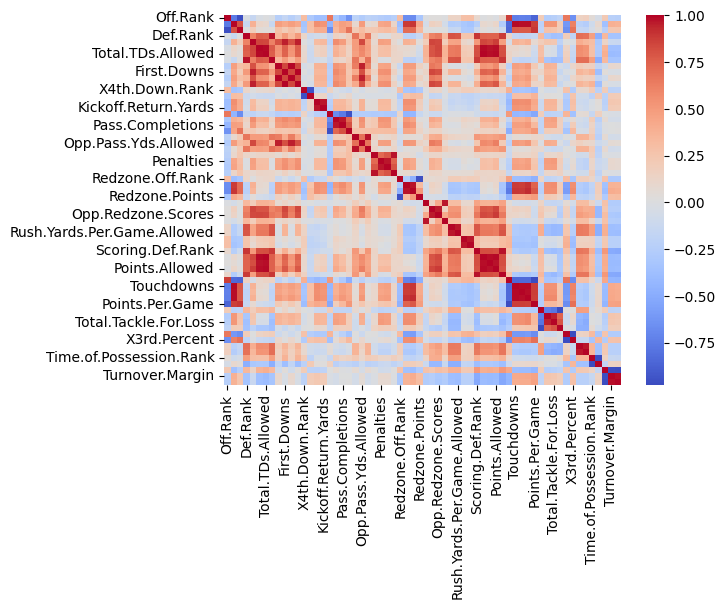

In [27]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_cols].corr()
corr_threshold = .95
mask = (corr_matrix.abs() >= corr_threshold) & (corr_matrix.abs() < 1)
corr_features = corr_matrix.columns[mask.any()]
corr_df = df[corr_features]
sns.heatmap(corr_df.corr(), annot=False, cmap='coolwarm')
plt.show()

We thought it would be interesting to see how balanced teams are. We can achieve this by taking a look at the defensive rankings of the best 25 offenses to see if teams choose to prioritzie one side of the ball.

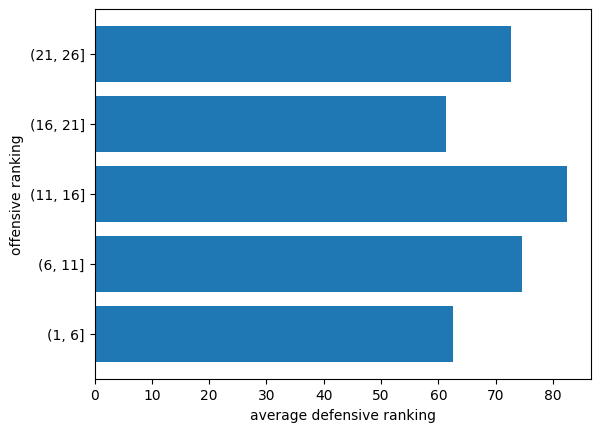

In [28]:
bins = list(range(1, 31, 5))
df_copy = df.copy(deep=True)
df_copy['bin'] = pd.cut(df_copy['Off.Rank'], bins)
bin_avgs = df_copy.groupby('bin')['Def.Rank'].mean()
plt.barh(bin_avgs.index.astype(str), bin_avgs)
plt.xlabel('average defensive ranking')
plt.ylabel('offensive ranking')
plt.show()

As we can see above, top 25 offenses are on average very pedestrian on defense.

We were curious in validating on if passing is becoming more prominent and the value of rushing is fading. Pass yards per game and rush yards per game can give us a good idea on this topic.

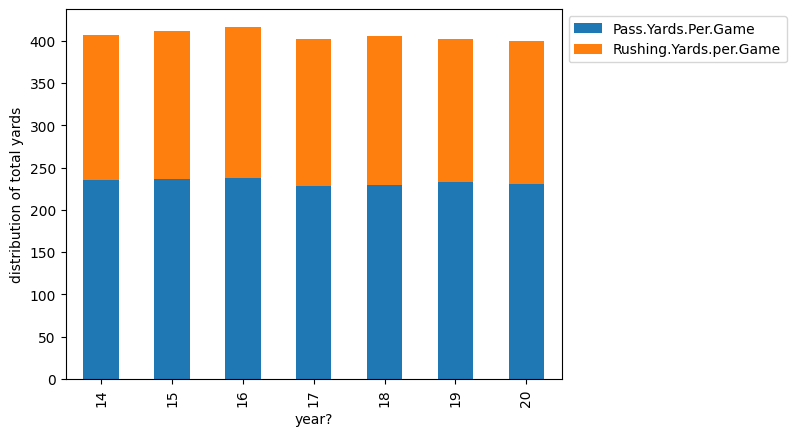

In [29]:
data = df.groupby('year')[['Pass.Yards.Per.Game', 'Rushing.Yards.per.Game']].mean()
data.plot(kind='bar', stacked=True)
plt.xlabel('year?')
plt.ylabel('distribution of total yards')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

The above graph shows consistency in how temas have gained yards over the years.

On the topic of health, there have been rules put in place to deincentivize teams from trying to return kickoffs as they can be one of the most dangerous plays in football due to players running full speed at each other from oppositie sides of the field. We wanted to examine if there is an observable decrease following these new rules.

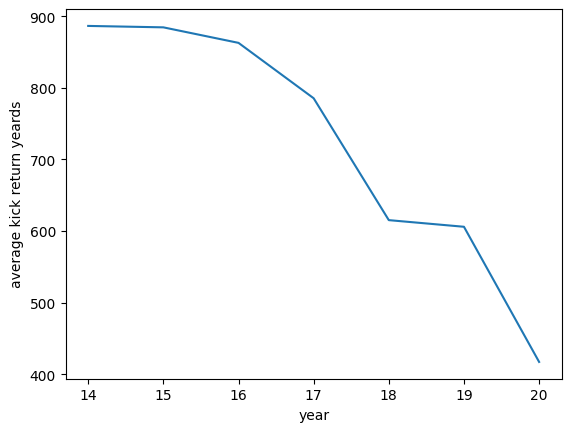

Text(0, 0.5, 'average kickoffs returned')

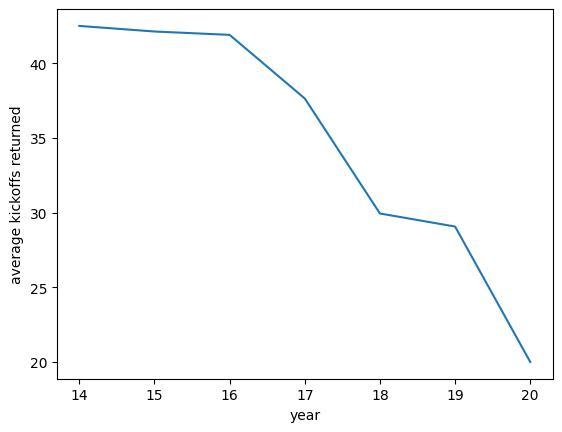

In [30]:
data = df.groupby('year')['Kickoff.Return.Yards'].mean()
data.plot(kind='line')
plt.xlabel('year')
plt.ylabel('average kick return yeards')
plt.show()
data = df.groupby('year')['Kickoffs.Returned'].mean()
data.plot(kind='line')
plt.xlabel('year')
plt.ylabel('average kickoffs returned')

## Feature Engineering

There are features that record the number of pass attempts and and pass completions a team had. We can make a completion percentage feature out of this to express the odds a pass will be succesfully completed when a team chooses to throw. 

We will drop the number of completions since we now have this completion percentage feature, but we will keep the number of pass attempts a team has since that describes their play style, which could determine how successful they are.

In [31]:
df['complt perct'] = df['Pass.Completions'] / df['Pass.Attempts']
df = df.drop(columns='Pass.Completions')

There are features that record the number of pass attempts faced and and pass completions allowed a team had. We can make an opponent completion percentage feature out of this to express the odds a pass will be succesfully completed against this team when they face a pass.

We will drop the number of completions allowed since we now have this opponent completion percentage feature, but we will keep the number of pass attempts a team faces since that describes how opponents play against this team, which could determine how successful they are.

In [32]:
df['opp complt perct'] = df['Opp.Completions.Allowed'] / df['Opp.Pass.Attempts']
df = df.drop(columns='Opp.Completions.Allowed')

The best teams when they are in the redzone(the last 20 yards before the endzone) score touchdowns(6 points) when they are that close opposed to settling for field goals(3 points) or not scoring at all. We can make a feature that expresses how often a team scores a touchdown when they are in the redzone. 

We will keep the amount of redzone attempts feature beacuse that tells us how many times a team gets into a close scoring poistion, which can say alot about how good or bad a team is.

In [33]:
df['redzone td perct'] = (df['Redzone.Rush.TD'] + df['Redzone.Pass.TD']) / df['Redzone.Attempts']

It is important to also know on what percentage of trips to the redzone a team settles for a field goal, so we can create a feature for that.

We can then drop the feature for the number of redzone field goals a team made after creating our redzone filed goal percentage feature.

In [34]:
df['redzone fg perct'] = df['Redzone.Field.Goals.Made'] / df['Redzone.Attempts']
df = df.drop(columns='Redzone.Field.Goals.Made')

We can then lastly make a feature to express the percentage of trips to the redzone a teams fails to score using the features we created above.

In [35]:
df['redzone empty perct'] = 1 - df['redzone td perct'] - df['redzone fg perct']

We can apply all the same logic above to create features for the opponents redzone statistis which can give us an idea of how good this teams' redzone defense is and if they can force their opponent into settling for field goals instead of scoring touchdowns.

In [36]:
df['opp redzone td perct'] = (df['Opp.Redzone.Rush.TD.Allowed'] + df['Opp.Redzone.Pass.Touchdowns.Allowed']) / df['Opp.Redzone.Attempts']
df['opp redzone fg perct'] = df['Opp.Redzone.Field.Goals.Made'] / df['Opp.Redzone.Attempts']
df = df.drop(columns='Opp.Redzone.Field.Goals.Made')
df['opp redzone empty perct'] = 1 - df['opp redzone td perct'] - df['opp redzone fg perct']

Big plays are very critical to have as an offense and limit as a defense in football. We can create features expressing for a team the number of touchdowns they scored and allowed outside the redzone(scores of over 20 yards).

We can subsequently drop the amount of redzone rush and pass touchdowns a team has had and allowed after creating the redzone touchdown percentage feature above and this non redzone touhchdown feature below.

In [37]:
df['non redzone td'] = df['Off.TDs'] - (df['Redzone.Rush.TD'] + df['Redzone.Pass.TD'])
df['non redzone td allowed'] = df['Off.TDs.Allowed'] - (df['Opp.Redzone.Rush.TD.Allowed'] + df['Opp.Redzone.Pass.Touchdowns.Allowed'])
columns_to_drop = ['Redzone.Rush.TD', 'Redzone.Pass.TD', 'Opp.Redzone.Rush.TD.Allowed', 'Opp.Redzone.Pass.Touchdowns.Allowed']
df = df.drop(columns=columns_to_drop)

The number of games teams play can vary based on if they qualified for their conference championship or not, and during the Covid-19 pandemic, some conferences played a drastically different amount of games than others. For these reasons, it would make more sense to use win percentage rather than just number of wins in our model.

We can subsequently drop the number of wins, lossess, and games played from our dataframe after creating our win percentage feature.

In [38]:
df['win perct'] = df['Win'] / df['Games']
columns_to_drop = ['Win', 'Loss', 'Games']
df = df.drop(columns=columns_to_drop)

The conference a team is plays a big role in how the commitee ranks them. Most of the games teams play are against teams in the same conference, and some conferences have historically had higher performing teams. As a result, teams in these more elite conferences often have harder schedules, and thus it is critical to take into consideration the conference a team plays in when ranking them.

In our datasets, the conference is not its own feature, it is attached to the feature for the team's name. Hence, we parse the conference from the team's name and add a column for the conference the team is in.

After we parse the conference from the team name feature and create the conference feature, we can remove the conference from the team name.

In [39]:
df['conference'] = df['Team'].apply(lambda x: x[x.find('(') + 1: x.find(')')] if '(' in x and ')' in x else x)
df['Team'] = df['Team'].apply(lambda x: x[:x.find('(')] if '(' in x else x)
df['Team'] = df['Team'].str[:-1]

There were a couple individual records with missing/wrong conferences, so we manually set the teams' conference to its correct one.

In [40]:
df.loc[df['conference'] == 'Independent', 'conference'] = 'FBS Independent'
df.loc[(df['conference'] == '') & (df['Team'] == 'Ole Miss'), 'conference'] = 'SEC'
df.loc[(df['conference'] == '') & (df['Team'] == 'Pittsburgh'), 'conference'] = 'ACC'

Our class label is if the team was ranked in the top 25 or not for the given year, so we utilize the lists below to add a column which holds a 1 if the team was ranked in the top 25 that year and a 0 if not.

After we create the feature that says if a team was in the top 25 or not for the given year, we can drop the year column, as well as drop the name of the team since we don't want the name of a team to be impacting our model.

In [41]:
# lists of the CFP Commitee's top 25 ranking each year

top25_14 = ['Alabama', 'Oregon', 'Florida St.', 'Ohio St.', 'Baylor',
            'TCU', 'Mississippi St.', 'Michigan St.', 'Ole Miss', 'Arizona',
            'Kansas St.', 'Georgia Tech', 'Georgia', 'UCLA', 'Arizona St.',
            'Missouri', 'Clemson', 'Wisconsin', 'Auburn', 'Boise St.',
            'Louisville', 'Utah', 'LSU', 'Southern California', 'Minnesota'] # top 25 from 2014

top25_15 = ['Clemson', 'Alabama', 'Michigan St.', 'Oklahoma', 'Iowa',
            'Stanford', 'Ohio St.', 'Notre Dame', 'Florida St.', 'North Carolina',
            'TCU', 'Ole Miss', 'Northwestern', 'Michigan', 'Oregon',
            'Oklahoma St.', 'Baylor', 'Houston', 'Florida', 'LSU',
            'Navy', 'Utah', 'Tennessee', 'Temple', 'Southern California'] # top 25 from 2015

top25_16 = ['Alabama', 'Clemson', 'Ohio St.', 'Washington', 'Penn St.',
            'Michigan', 'Oklahoma', 'Wisconsin', 'Southern California', 'Colorado',
            'Florida St.', 'Oklahoma St.', 'Louisville', 'Auburn', 'Western Mich.',
            'West Virginia', 'Florida', 'Stanford', 'Utah', 'LSU',
            'Tennessee', 'Virginia Tech', 'Pittsburgh', 'Temple', 'Navy'] # top 25 from 2016

top25_17 = ['Clemson', 'Oklahoma', 'Georgia', 'Alabama', 'Ohio St.',
            'Wisconsin', 'Auburn', 'Southern California', 'Penn St.', 'Miami FL',
            'Washington', 'UCF', 'Stanford', 'Notre Dame', 'TCU',
            'Michigan St.', 'LSU', 'Washington St.', 'Oklahoma St.', 'Memphis',
            'Northwestern', 'Virginia Tech', 'Mississippi St.', 'NC State', 'Boise St.'] # top 25 from 2017

top25_18 = ['Alabama', 'Clemson', 'Notre Dame', 'Oklahoma', 'Georgia',
            'Ohio St.', 'Michigan', 'UCF', 'Washington', 'Florida',
            'LSU', 'Penn St.', 'Washington St.', 'Kentucky', 'Texas',
            'West Virginia', 'Utah', 'Mississippi St.', 'Texas A&M', 'Syracuse',
            'Fresno St.', 'Northwestern', 'Missouri', 'Iowa St.', 'Boise St.'] # top 25 from 2018

top25_19 = ['LSU', 'Ohio St.', 'Clemson', 'Oklahoma', 'Georgia',
            'Oregon', 'Baylor', 'Wisconsin', 'Florida', 'Penn St.',
            'Utah', 'Auburn', 'Alabama', 'Michigan', 'Notre Dame',
            'Iowa', 'Memphis', 'Minnesota', 'Boise St.', 'Appalachian St.',
            'Cincinnati', 'Southern California', 'Navy', 'Virginia', 'Oklahoma St.'] # top 25 from 2019

top25_20 = ['Alabama', 'Clemson', 'Ohio St.', 'Notre Dame', 'Texas A&M',
            'Oklahoma', 'Florida', 'Cincinnati', 'Georgia', 'Iowa St.',
            'Indiana', 'Coastal Carolina', 'North Carolina', 'Northwestern', 'Iowa',
            'BYU', 'Southern California', 'Miami FL', 'Louisiana', 'Texas',
            'Oklahoma St.', 'San Jose St.', 'NC State', 'Tulsa', 'Oregon'] # top 25 from 2020

top25_dict = {14: top25_14, 15: top25_15, 16: top25_16, 17: top25_17, 18: top25_18,
              19: top25_19, 20: top25_20} # dictionary to be able to grab rankings for a desired year

df['top 25'] = df.apply(lambda row: 1 if row['Team'] in top25_dict.get(row['year'], []) else 0, axis=1)
df = df.drop(columns='year')
df = df.drop(columns='Team')

The below features are being dropped beacause there is already a feature in our dataframe that is a calculation of these features.

In [42]:
columns_to_drop = ['Off.Plays', 'Def.Plays', 'X4th.Conversions', 'Opp.4th.Conversion',
                   'Kickoffs.Returned', 'Kickoff.Return.Yards', 'Punt.Returns', 'Net.Punt.Return.Yards',
                   'Opp.Punt.Returns', 'Opp.Net.Punt.Return.Yards', 'Redzone.Points', 'Redzone.Points.Allowed',
                   'X3rd.Attempts', 'X3rd.Conversions', 'Opp.3rd.Attempt', 'Opp.3rd.Conversion']
df = df.drop(columns=columns_to_drop)

## Additional Data Exploration

Taking another look at our data after feature engineering.

In [43]:
df.shape

(859, 130)

In [44]:
df.head()

,Off.Rank,Off.Yards,Off.Yards.Play,Off.TDs,Off.Yards.per.Game,Def.Rank,Yards.Allowed,Yards.Play.Allowed,Off.TDs.Allowed,Total.TDs.Allowed,...,redzone fg perct,redzone empty perct,opp redzone td perct,opp redzone fg perct,opp redzone empty perct,non redzone td,non redzone td allowed,win perct,conference,top 25
0,88,4479,5.03,32,373.3,44,4453,5.18,34,35,...,0.191489,0.319149,0.536585,0.219512,0.243902,9,12,0.416667,MAC,0
1,17,6783,6.66,67,484.5,12,4598,4.87,24,27,...,0.156250,0.140625,0.386364,0.454545,0.159091,22,7,0.857143,SEC,1
2,25,6491,5.70,55,463.6,103,6314,5.66,47,49,...,0.250000,0.200000,0.603774,0.283019,0.113208,22,15,0.714286,Pac-12,1
3,34,5750,5.90,54,442.3,81,5422,5.62,39,46,...,0.281250,0.093750,0.565217,0.195652,0.239130,14,13,0.769231,Pac-12,1
4,60,5278,5.76,52,406.0,10,4204,5.12,30,33,...,0.142857,0.214286,0.606061,0.090909,0.303030,16,10,0.538462,SEC,0


In [45]:
df.describe()

,Off.Rank,Off.Yards,Off.Yards.Play,Off.TDs,Off.Yards.per.Game,Def.Rank,Yards.Allowed,Yards.Play.Allowed,Off.TDs.Allowed,Total.TDs.Allowed,...,redzone td perct,redzone fg perct,redzone empty perct,opp redzone td perct,opp redzone fg perct,opp redzone empty perct,non redzone td,non redzone td allowed,win perct,top 25
count,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,...,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000
mean,64.296857,4939.233993,5.745693,42.295693,406.274854,64.273574,4774.155995,5.633003,39.295693,41.784633,...,0.610655,0.221110,0.168235,0.599797,0.227419,0.172784,13.746217,12.817229,0.518121,0.202561
std,37.229542,1195.929915,0.736567,14.786471,63.690347,37.015726,953.750514,0.676847,11.776715,12.342110,...,0.088995,0.076011,0.066954,0.093716,0.075621,0.063893,6.403732,5.424230,0.223505,0.402142
min,1.000000,750.000000,3.380000,1.000000,187.500000,1.000000,1167.000000,3.990000,6.000000,6.000000,...,0.320000,0.000000,0.000000,0.242424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,4289.000000,5.260000,32.000000,366.800000,32.000000,4345.500000,5.160000,31.000000,34.000000,...,0.550000,0.166667,0.119403,0.545455,0.176471,0.127660,9.000000,9.000000,0.333333,0.000000
50%,64.000000,4982.000000,5.700000,41.000000,402.700000,64.000000,4883.000000,5.610000,39.000000,42.000000,...,0.614035,0.214286,0.162162,0.600000,0.220339,0.166667,13.000000,12.000000,0.538462,0.000000
75%,97.000000,5703.500000,6.190000,52.000000,443.150000,96.000000,5392.000000,6.070000,47.000000,50.000000,...,0.669154,0.272727,0.210526,0.660357,0.275862,0.212121,18.000000,16.000000,0.692308,0.000000
max,130.000000,8526.000000,8.600000,93.000000,616.200000,130.000000,7409.000000,8.810000,82.000000,86.000000,...,0.846154,0.466667,0.500000,0.888889,0.575758,0.421053,40.000000,32.000000,1.000000,1.000000


To show why we would want to have a feature that says what conference a team is in, the below plot displays the distribution of ranked teams based on what conference they are in. As we can see, teams in the top 25 primarily come from a couple conferences.

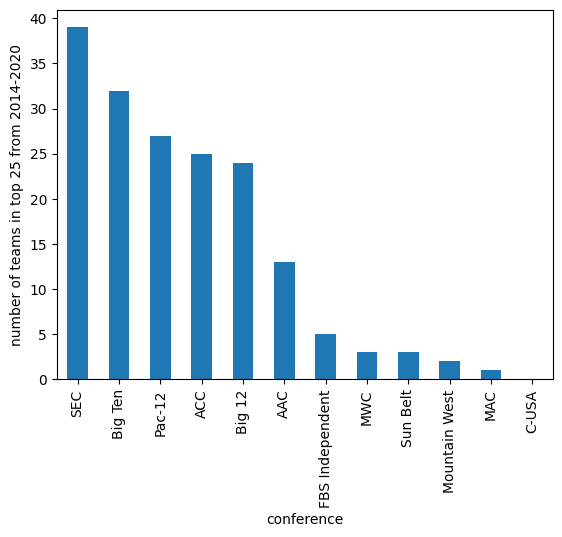

In [46]:
data = df.groupby('conference')['top 25'].sum()
data = data.sort_values(ascending=False)
data.plot(kind='bar')
plt.xlabel('conference')
plt.ylabel('number of teams in top 25 from 2014-2020')
plt.show()

This analysis of conferences can be taken further by looking at the distribution of the top 25 based on conference to see on average what proportion of ranked teams come from each conference.

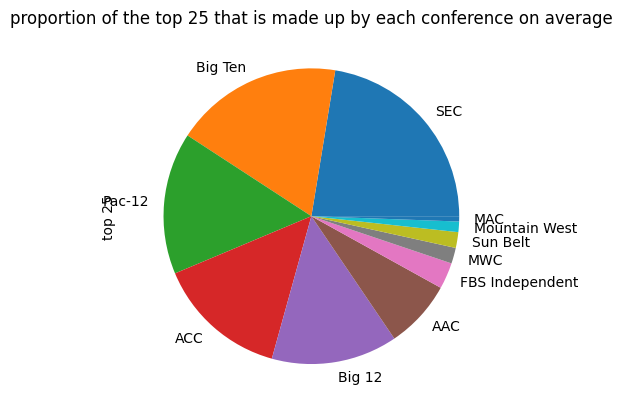

In [47]:
data = df.groupby('conference')['top 25'].sum()
data = data.sort_values(ascending=False)
data = data / num_years
data.plot(kind='pie')
plt.title('proportion of the top 25 that is made up by each conference on average')
plt.show()

An important feature we engineered was the percentage of time a team scores a touchdown when they are in the redzone. We can see the difference in the performance in the redzone for winning teams versus losing teams below.

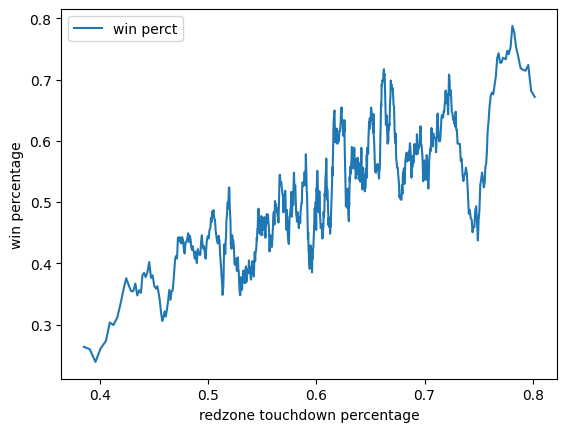

In [48]:
sorted_df = df.sort_values(by='redzone td perct')
window_size = 20
sorted_df['redzone td perct'] = sorted_df['redzone td perct'].rolling(window=window_size).mean()
sorted_df['win perct'] = sorted_df['win perct'].rolling(window=window_size).mean()
sorted_df.plot(x='redzone td perct', y='win perct')
plt.xlabel('redzone touchdown percentage')
plt.ylabel('win percentage')
plt.show()

A similar trend can be seen in the relationship between how long a team has the ball during the game and their win percentage.

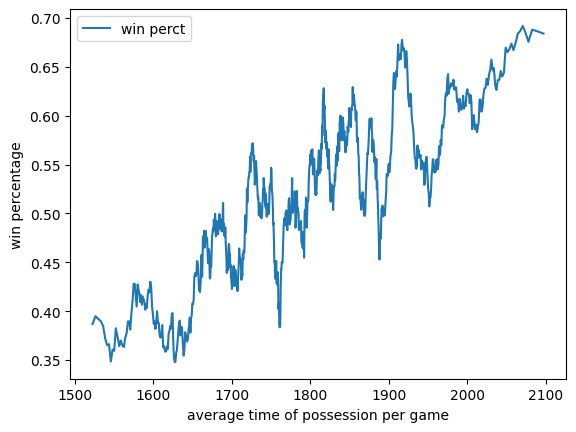

In [49]:
sorted_df = df.sort_values(by='Average.Time.of.Possession.per.Game')
window_size = 30
sorted_df['Average.Time.of.Possession.per.Game'] = sorted_df['Average.Time.of.Possession.per.Game'].rolling(window=window_size).mean()
sorted_df['win perct'] = sorted_df['win perct'].rolling(window=window_size).mean()
sorted_df.plot(x='Average.Time.of.Possession.per.Game', y='win perct')
plt.xlabel('average time of possession per game')
plt.ylabel('win percentage')
plt.show()

The above graphs show how scoring touchdowns when you are in the redzone and limiting the amount of time your opponent has the ball are keys to winning football games.

One of the most talked-about statistics in the media is the turnover margin. The turnover margin is the difference between the number of times a team took the ball away from their opponent and the number of times they gave the ball to their opponent. Good teams are known to have positive turnover margins, and we wanted to confirm that by plotting the average turnover margin for ranked teams versus those teams not in the top 25.

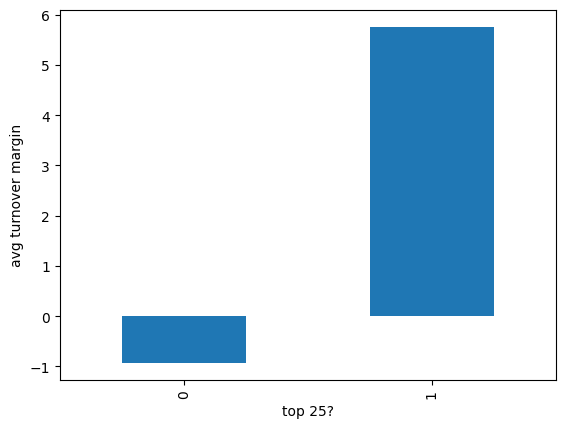

In [50]:
data = df.groupby('top 25')['Turnover.Margin'].mean()
data.plot(kind='bar')
plt.xlabel('top 25?')
plt.ylabel('avg turnover margin')
plt.show()

As shown above, bad teams give up the ball more than they take it away, and vice versa for good teams. 

## Modeling

Before we begin building models, we need to ensure that the conference is one hot encoded (since it's a categorical). As seen in our data exploration, conferences are very helpful in determining if a team will end up being ranked. This is because teams in the Power 5 conferences(SEC, Big 10, Big 12, ACC, and PAC 12) have a much higher likelihood of being ranked due to percieved strength of the conferences.

In [51]:
model_df = df.copy(deep=True)
one_hot = pd.get_dummies(model_df['conference'])
one_hot = one_hot.astype('int')
model_df = model_df.drop(columns='conference')
model_df.join(one_hot)

,Off.Rank,Off.Yards,Off.Yards.Play,Off.TDs,Off.Yards.per.Game,Def.Rank,Yards.Allowed,Yards.Play.Allowed,Off.TDs.Allowed,Total.TDs.Allowed,...,Big 12,Big Ten,C-USA,FBS Independent,MAC,MWC,Mountain West,Pac-12,SEC,Sun Belt
0,88,4479,5.03,32,373.3,44,4453,5.18,34,35,...,0,0,0,0,1,0,0,0,0,0
1,17,6783,6.66,67,484.5,12,4598,4.87,24,27,...,0,0,0,0,0,0,0,0,1,0
2,25,6491,5.70,55,463.6,103,6314,5.66,47,49,...,0,0,0,0,0,0,0,1,0,0
3,34,5750,5.90,54,442.3,81,5422,5.62,39,46,...,0,0,0,0,0,0,0,1,0,0
4,60,5278,5.76,52,406.0,10,4204,5.12,30,33,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,42,3804,5.51,28,422.7,5,2675,4.77,20,23,...,1,0,0,0,0,0,0,0,0,0
855,120,3200,4.58,21,290.9,21,3700,4.99,31,34,...,0,0,1,0,0,0,0,0,0,0
856,15,2878,7.34,32,479.7,60,2398,5.60,25,25,...,0,0,0,0,1,0,0,0,0,0
857,93,2153,5.00,17,358.8,1,1581,4.76,10,11,...,0,1,0,0,0,0,0,0,0,0


We also must seperate our features from our class labels before we start modeling.

In [52]:
features = model_df.drop(columns='top 25')
labels = model_df['top 25'].values.ravel()

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, ConfusionMatrixDisplay
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from mlxtend.classifier import StackingCVClassifier

In [54]:
#method to generate the statistics for our models
def generate_statistics(model, features, labels, folds, fit, linear):
    if(fit):
        model.fit(features, labels)
    scores = cross_val_score(model, features, labels, cv=folds)
    print("Average accuracy:", scores.mean() * 100, "%")
    predictions = cross_val_predict(model, features, labels, cv = folds)
    binary_predictions = []
    binary_predictions = []
    for i in predictions:
        if(i >= 0):
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
    if(linear):
        print(classification_report(labels, binary_predictions))
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(labels, binary_predictions)).plot()
    else:
        print(classification_report(labels, predictions))
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(labels, predictions)).plot()
    plt.show() 


#method to generate the roc curve for a model
#copied over from assignment 4
def generate_roc_curve(model, features, labels):
    model.fit(features, labels)
    predictions = model.predict_proba(features)

    # #replace these fpr and tpr with the results of your roc_curve
    fpr, tpr, _ = roc_curve(labels, predictions[:,1])

    # Do not change this code! This plots the ROC curve.
    # Just replace the fpr and tpr above with the values from your roc_curve
    plt.plot([0,1],[0,1],'k--') #plot the diagonal line
    plt.plot(fpr, tpr, label='NB') #plot the ROC curve
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('ROC Curve')
    plt.show()

Decision Trees

Average accuracy: 83.23065415476677 %
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       685
           1       0.65      0.52      0.58       174

    accuracy                           0.85       859
   macro avg       0.77      0.73      0.74       859
weighted avg       0.84      0.85      0.84       859



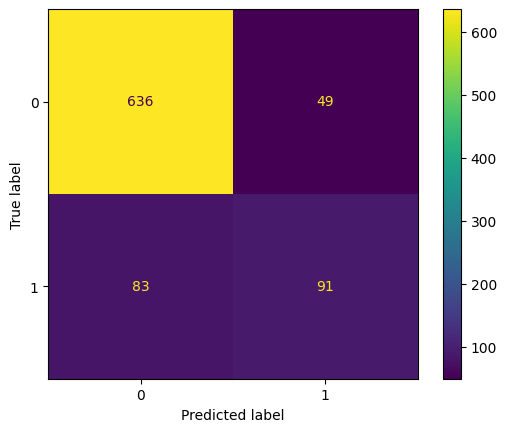

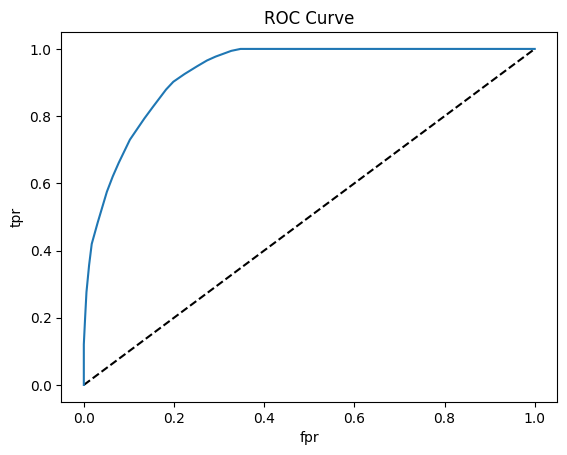

In [55]:
from sklearn.tree import DecisionTreeClassifier


clf = DecisionTreeClassifier()
param_grid = {'max_depth': [5, 10, 15, 20], 'min_samples_leaf': [5, 10, 15, 20], 'max_features': [5, 10, 15]}
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

generate_statistics(grid_search, features, labels, KFold(n_splits = 5, shuffle = True, random_state = 21), False, False)
generate_roc_curve(grid_search, features, labels)

Naive Bayes

Average accuracy: 81.03009575923392 %
              precision    recall  f1-score   support

           0       0.96      0.80      0.87       685
           1       0.52      0.86      0.65       174

    accuracy                           0.81       859
   macro avg       0.74      0.83      0.76       859
weighted avg       0.87      0.81      0.83       859



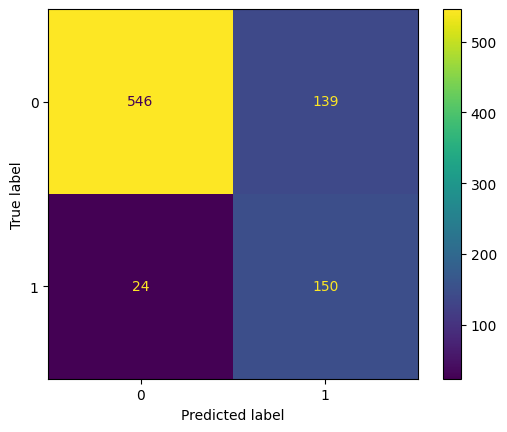

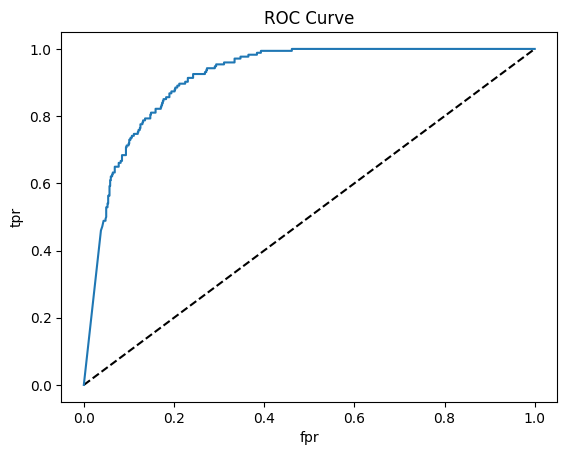

In [56]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
generate_statistics(gnb, features, labels, KFold(n_splits = 10, shuffle = True, random_state = 21), False, False)
generate_roc_curve(gnb, features, labels)

KNN

Average accuracy: 84.51516387868895 %
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       685
           1       0.70      0.37      0.48       174

    accuracy                           0.84       859
   macro avg       0.78      0.66      0.69       859
weighted avg       0.83      0.84      0.82       859



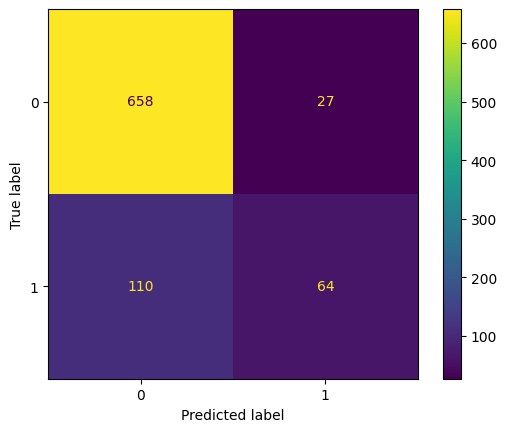

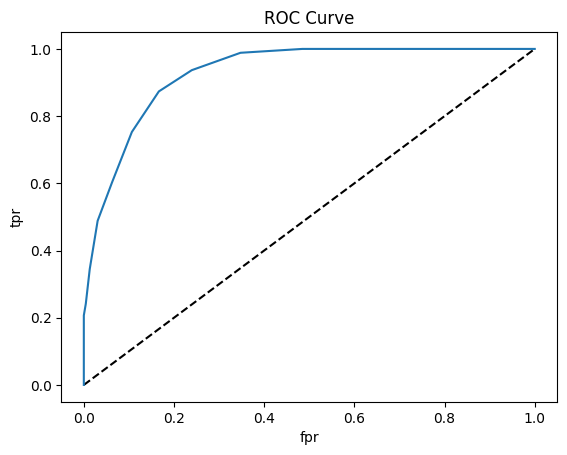

In [57]:
from sklearn.neighbors import KNeighborsClassifier

k_pl = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('knn', KNeighborsClassifier())])
param_grid = {'pca__n_components': list(range(5, 19)), 'knn__n_neighbors': list(range(1, 25))}

gr_sch = GridSearchCV(k_pl, param_grid, cv = 5)
generate_statistics(gr_sch, features, labels, KFold(n_splits = 5, shuffle = True, random_state = 21), True, False)
generate_roc_curve(gr_sch, features, labels)

SVM

Average accuracy: 86.3797089623283 %
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       685
           1       0.71      0.56      0.63       174

    accuracy                           0.86       859
   macro avg       0.80      0.75      0.77       859
weighted avg       0.86      0.86      0.86       859



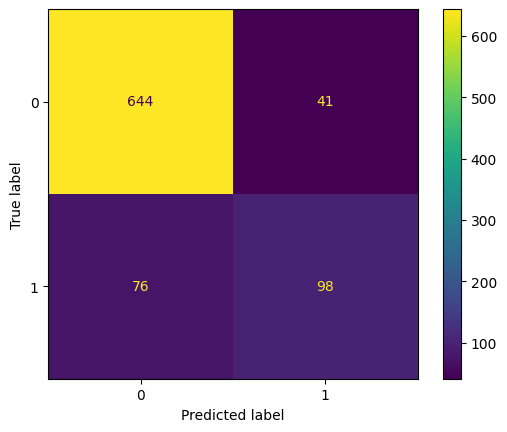

In [58]:
from sklearn.svm import SVC

svm_pl = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
prm_grd = { 'svc__C': [0.1, 1, 10, 100], 'svc__kernel': ['linear', 'rbf', 'poly']}
gr_sch = GridSearchCV(svm_pl, prm_grd, cv = 5)
generate_statistics(gr_sch, features, labels, KFold(n_splits = 5, shuffle = True, random_state = 21), False, False)


Neural Nets

Average accuracy: 87.07738338093294 %
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       685
           1       0.68      0.68      0.68       174

    accuracy                           0.87       859
   macro avg       0.80      0.80      0.80       859
weighted avg       0.87      0.87      0.87       859



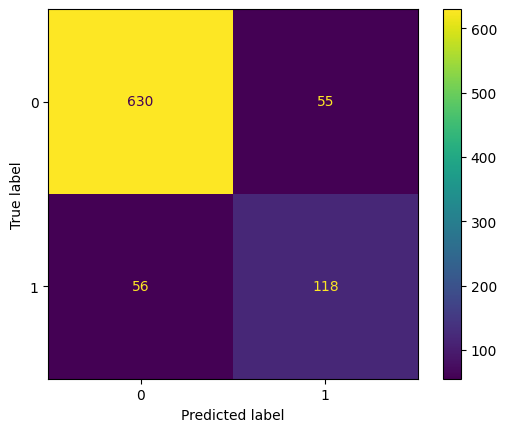

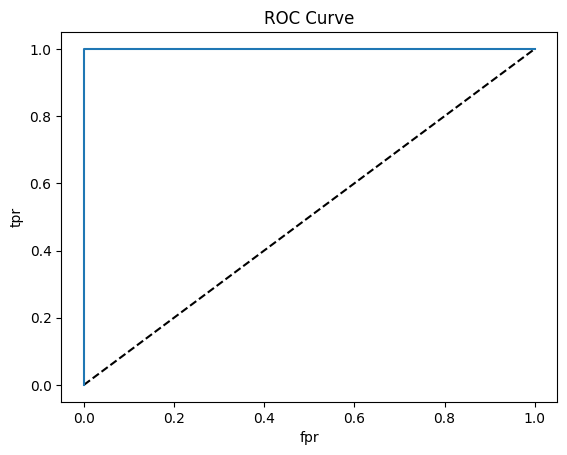

In [59]:
from sklearn.neural_network import MLPClassifier

@ignore_warnings(category=ConvergenceWarning)
def run_nn():
    pl = Pipeline([('scaler', StandardScaler()), ('mlp', MLPClassifier(max_iter = 1000, random_state = 21))])
    prm_grd = {'mlp__hidden_layer_sizes': [(30,), (40,), (50,), (60,)], 'mlp__activation': ['logistic', 'tanh', 'relu']}
    grid_search = GridSearchCV(pl, prm_grd, cv=5)
    generate_statistics(grid_search, features, labels, KFold(n_splits = 5, shuffle = True, random_state = 21), False, False)
    generate_roc_curve(grid_search, features, labels)
  

run_nn()

Random Forest Ensemble

Average accuracy: 87.31334149326804 %
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       685
           1       0.75      0.56      0.64       174

    accuracy                           0.87       859
   macro avg       0.82      0.76      0.78       859
weighted avg       0.87      0.87      0.87       859



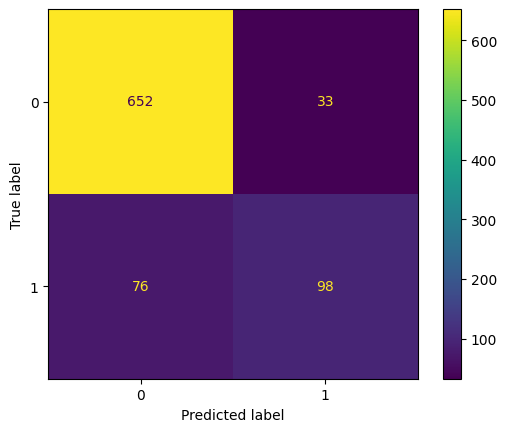

In [60]:
from sklearn.ensemble import RandomForestClassifier


rf_clf = RandomForestClassifier(random_state = 21)
prm_grd = {'n_estimators': [50, 100, 150]}
grd_sch = GridSearchCV(rf_clf, prm_grd, cv = 5)
generate_statistics(grd_sch, features, labels, KFold(n_splits = 5, shuffle = True, random_state = 21), False, False)


AdaBoost Classifier

Average accuracy: 86.61566707466338 %
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       685
           1       0.66      0.69      0.68       174

    accuracy                           0.87       859
   macro avg       0.79      0.80      0.80       859
weighted avg       0.87      0.87      0.87       859



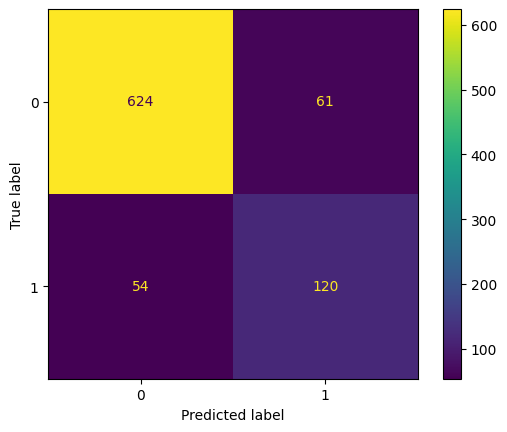

In [61]:
from sklearn.ensemble import AdaBoostClassifier
params = {"n_estimators": [50,100,150]}
grid_forest = GridSearchCV(AdaBoostClassifier(), params, cv = 5)
generate_statistics(grid_forest, features, labels, KFold(n_splits = 5, shuffle = True, random_state = 21), False, False)

Average accuracy: 34.12669912358244 %
              precision    recall  f1-score   support

           0       1.00      0.27      0.43       685
           1       0.26      1.00      0.41       174

    accuracy                           0.42       859
   macro avg       0.63      0.64      0.42       859
weighted avg       0.85      0.42      0.42       859



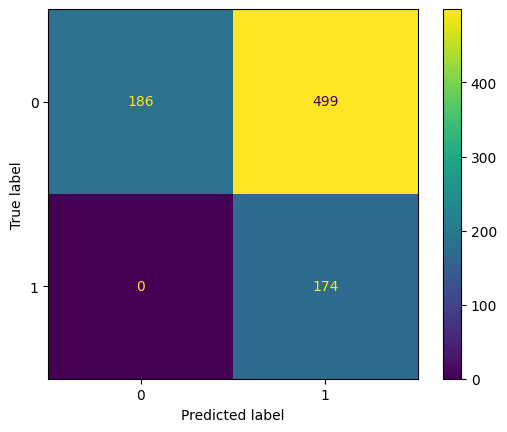

In [62]:
from sklearn.linear_model import ElasticNet
@ignore_warnings(category=ConvergenceWarning)
def run_elastic_net():
    prm_grd = {'l1_ratio': [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]}
    model = ElasticNet()
    grd_sch = GridSearchCV(model, prm_grd, cv = 5)
    generate_statistics(grd_sch, features, labels, KFold(n_splits = 5, shuffle = True, random_state = 21), False, True)
    

run_elastic_net()

Trying an ensembling of all our "best" models.

We chose the models that had the highest percision for class 1 (making the top 25)

Average accuracy: 86.72786617707058 %
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       685
           1       0.70      0.63      0.66       174

    accuracy                           0.87       859
   macro avg       0.80      0.78      0.79       859
weighted avg       0.87      0.87      0.87       859



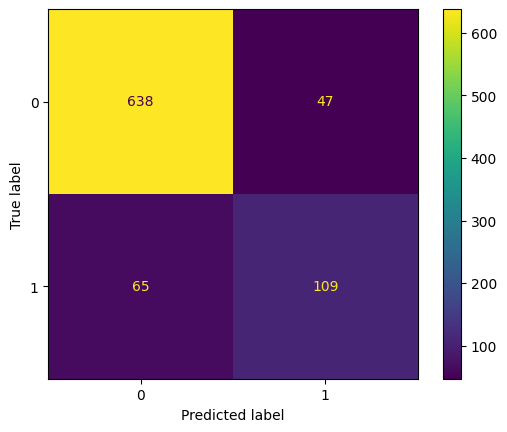

In [63]:
scv=StackingCVClassifier(classifiers=[SVC(), KNeighborsClassifier(), MLPClassifier(), RandomForestClassifier(), AdaBoostClassifier()], meta_classifier=RandomForestClassifier())
generate_statistics(scv, features, labels, 5, False, False)


## Results

In general, all of our models had very strong accuracies (nearly all had over 80%). Additionally, they also performed very well in the classification of class 0 (unrakned).
Many of our models had percisions, recalls, and f-scores in the .9s for class 0.

This makes some sense because the majority of the teams end up not ranked, and there are a lot of variables that our models can select upon to make this decision. As seen through our data exploration, features (besides the obvious one of win %) such as the turnover margin & redzone prediction can heavily show if a team will end up ranked or unranked, and our models can select upon these to determine whether a team will be in class 0.

The problem specifically becomes in trying to predict if a team will end up as class 1 (ranked). 
Our best models only had percisions of .75, but came at a steep cost in recall. Likewise, models that had good recall had extremely poor percision. Additionally, the models still couldn't get an f-score above .7
This is because there is such a fine line between whether a team will be ranked, or if a team will end up in the outside fringes. For example, in the year 2017 teams like Army, Troy, and Toledo performed very well compared to counterparts that were in the top 25, such as Washington St. This is because the rankings at the end of the day are still done by humans, and they'll end up favoring the power 5 conferences over the non power 5, even though the analytics and teams performance clearly indicates otherwise.

The most dissapointing model for us was the elastic net. We thought that this would be somewhat good for our data set because it acted as a hybrid between the Lasso regressor model & the Ridge regressor model. This meant that in a sparse data set (like our model because it had few points), it'd try and select features that have a lot of correlation together (which our model also had) to try and make predictions. The reason why we think our elastic net failed is because there were just too many parameters for us to select between, and there's no guarantee that the highly correlated variables will actually lead towards a good prediction (which is what ended up happening).

Ultimately, we think that the best models for a potential athletic department to use would be the KNN, SVM, Neural Net, and either of the ensemble methods. This is because these models have better/more balanced percision for class 1 & have more false negatives than false positives. For an athletic department, a false negative would end up beinga better result than a false positive. This is because if a team ran the model prior to the committee's final selection of whether a team is ranked & got a false negative, then they'd just be prepared to be unranked only to be surprised when they are actually ranked. However if a department got a false positive, they could prepare to use this as a recruiting & advertising point only for it to be removed away from them.